In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt # We will be using Matplotlib for our graphs
import os
from sklearn.model_selection import train_test_split # A library that can automatically perform data splitting for us
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report, balanced_accuracy_score # Various classification metrics we may find useful

import tensorflow as tf # loads all of tensorflow. This gives us access to everything, but we need to call the correct library
from tensorflow import keras # karas is a hgiher level library built on tensorflow. Most of what we are doing is actually using keras.
from tensorflow.keras import layers, datasets # Import the different model layers and datasets
import tensorflow_datasets as tfds # An alternate way to load tensorflow datasets
from tensorflow.keras.preprocessing.image import load_img, img_to_array # Some tensofrlow preprocessing librarie we need to load in local image files
from keras.models import Model # We'll be using the functional/graphical api for our CNNs
from tensorflow.keras.models import Sequential
%matplotlib inline

In [ ]:
!unzip metalImages.zip

Archive:  COMP1801_CourseworkDataset2_images.zip
   creating: COMP1801_CourseworkDataset2_images/
  inflating: COMP1801_CourseworkDataset2_images/COMP1801_CourseworkDataset2_images_metadata.csv  
 extracting: COMP1801_CourseworkDataset2_images/scan_0.png  
 extracting: COMP1801_CourseworkDataset2_images/scan_1.png  
 extracting: COMP1801_CourseworkDataset2_images/scan_10.png  
 extracting: COMP1801_CourseworkDataset2_images/scan_100.png  
 extracting: COMP1801_CourseworkDataset2_images/scan_101.png  
 extracting: COMP1801_CourseworkDataset2_images/scan_102.png  
 extracting: COMP1801_CourseworkDataset2_images/scan_103.png  
 extracting: COMP1801_CourseworkDataset2_images/scan_104.png  
 extracting: COMP1801_CourseworkDataset2_images/scan_105.png  
 extracting: COMP1801_CourseworkDataset2_images/scan_106.png  
 extracting: COMP1801_CourseworkDataset2_images/scan_107.png  
 extracting: COMP1801_CourseworkDataset2_images/scan_108.png  
 extracting: COMP1801_CourseworkDataset2_images/scan_

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import os
import numpy as np


metadata = pd.read_csv("/content/COMP1801_CourseworkDataset2_images/COMP1801_CourseworkDataset2_images_metadata.csv")


type_mapping = {
    "Splinter": 2,
    "None": 3,
    "Multiple": 4,
    "Large": 5,
}
defect_mapping={
    "Yes":1,
    "No":0,
}

metadata['Type'] = metadata['Type'].map(type_mapping)
metadata['Defect'] = metadata['Defect'].map(defect_mapping)

print("Unique values in 'Type' column after mapping:", metadata['Type'].unique())


image_directory = "/content/COMP1801_CourseworkDataset2_images/"

# Define image size
image_size = (100, 100)


images = []
labels = []


for index, row in metadata.iterrows():
    image_path = os.path.join(image_directory, row['Image Filename'])
    image = load_img(image_path, target_size=image_size)
    image_array = img_to_array(image) / 255.0  # Normalize pixel values to [0, 1]
    images.append(image_array)


    defect_label = row['Defect']
    type_label = row['Type']


    labels.append((defect_label, type_label))


images = np.array(images)
labels = np.array(labels)


print("Images Shape:", images.shape)
print("Labels Shape:", labels.shape)

Unique values in 'Type' column after mapping: [2 3 4 5]
Images Shape: (1000, 100, 100, 3)
Labels Shape: (1000, 2)


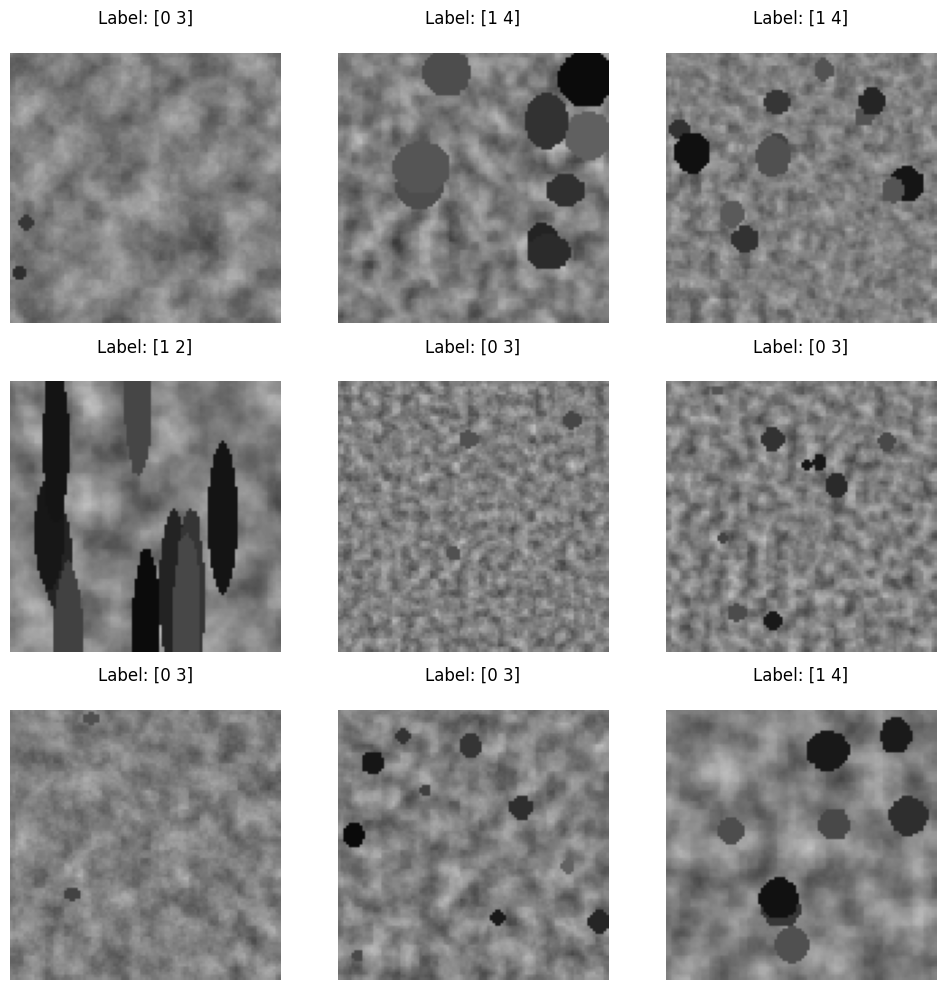

In [ ]:
num_images_to_visualize = 9

num_rows = 3
num_columns = num_images_to_visualize // num_rows


subset_indices = np.random.choice(20, num_images_to_visualize, replace=False)


fig, axes = plt.subplots(num_rows, num_columns, figsize=(10, 10))


for i, index in enumerate(subset_indices):
    row = i // num_columns
    col = i % num_columns

    imd=(images[index]*255).astype(np.uint8)


    axes[row, col].imshow(imd)
    axes[row, col].axis('off')


    title = f"Label: {labels[index]}\n"
    axes[row, col].set_title(title)


plt.tight_layout()
plt.show()

In [ ]:
images = np.array(images)
labels = np.array(labels)


print(labels)

[[1 2]
 [0 3]
 [1 4]
 ...
 [0 3]
 [0 3]
 [1 4]]


In [ ]:
from sklearn.model_selection import train_test_split


train_images, temp_images, train_labels, temp_labels = train_test_split(images, labels, test_size=0.4, random_state=42)


val_images, test_images, val_labels, test_labels = train_test_split(temp_images, temp_labels, test_size=0.5, random_state=42)


train_defect_labels, train_type_labels = train_labels[:, 0], train_labels[:, 1]
val_defect_labels, val_type_labels = val_labels[:, 0], val_labels[:, 1]
test_defect_labels, test_type_labels = test_labels[:, 0], test_labels[:, 1]


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

input_layer = Input(shape=(100, 100, 3))

# Convolutional layers
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)


shared = Dense(64, activation='relu')(x)
shared = Dropout(0.5)(shared)


defect_output = Dense(1, activation='sigmoid', name='defect_output')(shared)


type_output = Dense(6, activation='softmax', name='type_output')(shared)

model = Model(inputs=input_layer, outputs=[defect_output, type_output])


model.compile(optimizer='adam',
              loss={'defect_output': 'binary_crossentropy', 'type_output': 'sparse_categorical_crossentropy'},
              metrics={'defect_output': 'accuracy', 'type_output': 'accuracy'})

# Summary of the model
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 98, 98, 32)           896       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 47, 47, 64)           18496     ['max_pooling2d[0][0]']   

In [ ]:
model.compile(optimizer='adam',
              loss={'defect_output': 'binary_crossentropy',
                    'type_output': 'sparse_categorical_crossentropy'},
              metrics={'defect_output': 'accuracy',
                       'type_output': 'accuracy'})


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Assuming you have a model defined as 'model'

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)
# Model training with early stopping
history = model.fit(train_images,
                    {'defect_output': train_defect_labels, 'type_output': train_type_labels},
                    epochs=100,
                    batch_size=32,
                    validation_data=(val_images, {'defect_output': val_defect_labels, 'type_output': val_type_labels}),
                    callbacks=[early_stopping])


Epoch 1/100
19/19 [==============================] - 8s 59ms/step - loss: 1.9451 - defect_output_loss: 0.7280 - type_output_loss: 1.2171 - defect_output_accuracy: 0.6033 - type_output_accuracy: 0.5483 - val_loss: 1.5282 - val_defect_output_loss: 0.5960 - val_type_output_loss: 0.9322 - val_defect_output_accuracy: 0.6100 - val_type_output_accuracy: 0.6050
Epoch 2/100
19/19 [==============================] - 0s 15ms/step - loss: 1.4087 - defect_output_loss: 0.5269 - type_output_loss: 0.8818 - defect_output_accuracy: 0.7483 - type_output_accuracy: 0.6883 - val_loss: 1.0826 - val_defect_output_loss: 0.3660 - val_type_output_loss: 0.7166 - val_defect_output_accuracy: 0.9000 - val_type_output_accuracy: 0.7900
Epoch 3/100
19/19 [==============================] - 0s 17ms/step - loss: 1.0203 - defect_output_loss: 0.3281 - type_output_loss: 0.6922 - defect_output_accuracy: 0.8933 - type_output_accuracy: 0.7883 - val_loss: 0.9112 - val_defect_output_loss: 0.2759 - val_type_output_loss: 0.6354 - va

In [ ]:

defect_accuracy = history.history['defect_output_accuracy']
val_defect_accuracy = history.history['val_defect_output_accuracy']
defect_loss = history.history['defect_output_loss']
val_defect_loss = history.history['val_defect_output_loss']

print("Defect Detection - Training Accuracy: ", defect_accuracy[-1])
print("Defect Detection - Validation Accuracy: ", val_defect_accuracy[-1])
print("Defect Detection - Training Loss: ", defect_loss[-1])
print("Defect Detection - Validation Loss: ", val_defect_loss[-1])


type_accuracy = history.history['type_output_accuracy']
val_type_accuracy = history.history['val_type_output_accuracy']
type_loss = history.history['type_output_loss']
val_type_loss = history.history['val_type_output_loss']

print("\nDefect Type Classification - Training Accuracy: ", type_accuracy[-1])
print("Defect Type Classification - Validation Accuracy: ", val_type_accuracy[-1])
print("Defect Type Classification - Training Loss: ", type_loss[-1])
print("Defect Type Classification - Validation Loss: ", val_type_loss[-1])


Defect Detection - Training Accuracy:  0.9700000286102295
Defect Detection - Validation Accuracy:  0.925000011920929
Defect Detection - Training Loss:  0.10086444020271301
Defect Detection - Validation Loss:  0.25246939063072205

Defect Type Classification - Training Accuracy:  0.9133333563804626
Defect Type Classification - Validation Accuracy:  0.8450000286102295
Defect Type Classification - Training Loss:  0.2495930790901184
Defect Type Classification - Validation Loss:  0.6208141446113586


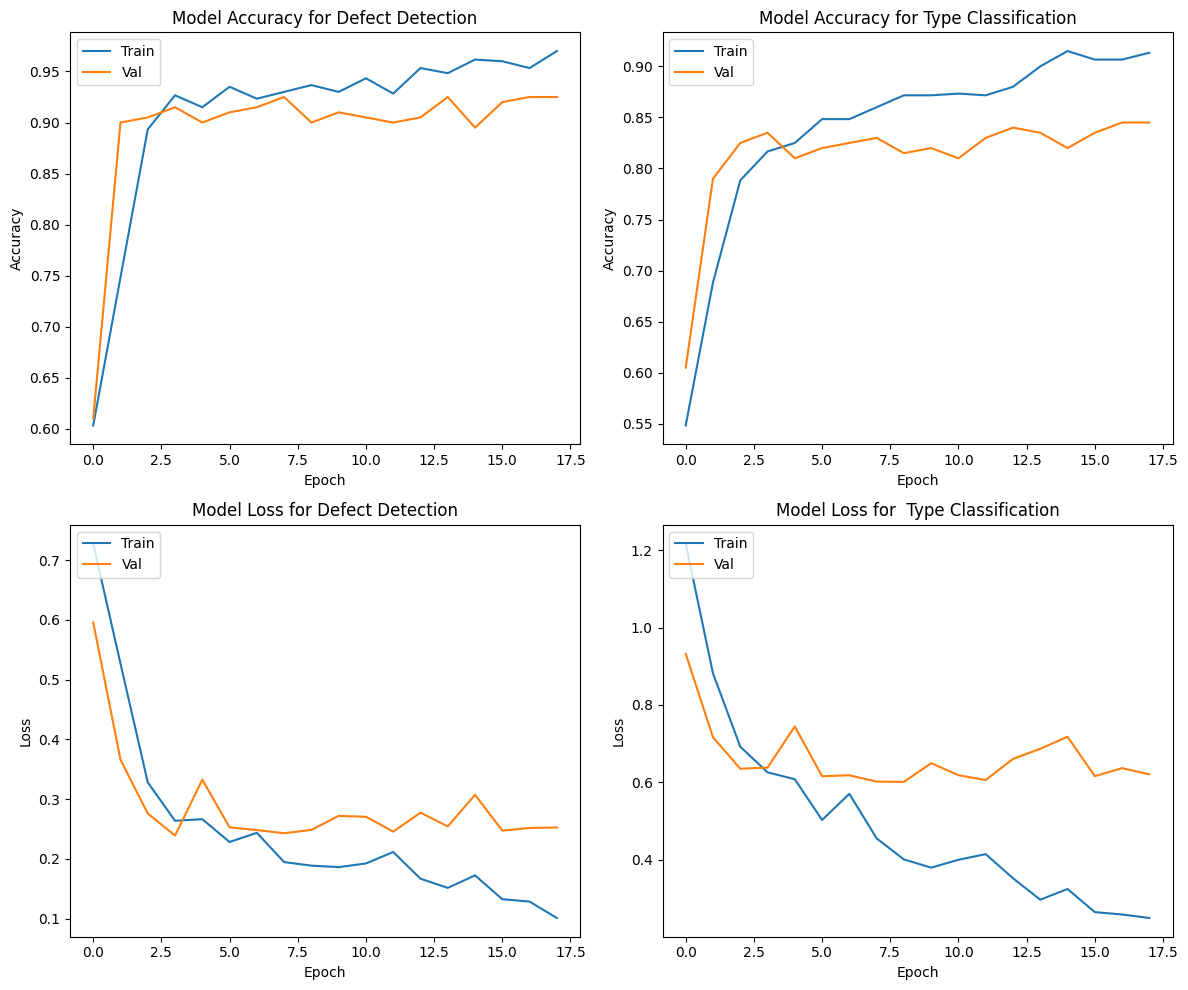

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['defect_output_accuracy'])
plt.plot(history.history['val_defect_output_accuracy'])
plt.title('Model Accuracy for Defect Detection')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')


plt.subplot(2, 2, 2)
plt.plot(history.history['type_output_accuracy'])
plt.plot(history.history['val_type_output_accuracy'])
plt.title('Model Accuracy for Type Classification')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')


plt.subplot(2, 2, 3)
plt.plot(history.history['defect_output_loss'])
plt.plot(history.history['val_defect_output_loss'])
plt.title('Model Loss for Defect Detection')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')


plt.subplot(2, 2, 4)
plt.plot(history.history['type_output_loss'])
plt.plot(history.history['val_type_output_loss'])
plt.title('Model Loss for  Type Classification')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')


plt.tight_layout()
plt.show()


In [ ]:

predictions = model.predict(test_images)



predicted_defect_labels = (predictions[0] > 0.5).astype(int)  # Assuming sigmoid activation


predicted_type_labels = np.argmax(predictions[1], axis=1)


accuracy_defect = accuracy_score(test_defect_labels, predicted_defect_labels)
accuracy_type = accuracy_score(test_type_labels, predicted_type_labels)

print("Defect Detection - Accuracy:", accuracy_defect)
print("Defect Type Classification - Accuracy:", accuracy_type)


conf_matrix_type = confusion_matrix(test_type_labels, predicted_type_labels)
class_report_type = classification_report(test_type_labels, predicted_type_labels)

print("Confusion Matrix - Defect Type:\n", conf_matrix_type)
print("Classification Report - Defect Type:\n", class_report_type)

conf_matrix_defect = confusion_matrix(test_defect_labels, predicted_defect_labels)
class_report_defect = classification_report(test_defect_labels, predicted_defect_labels)

print("Confusion Matrix - Defect Detection:\n", conf_matrix_defect)
print("Classification Report - Defect Detection:\n", class_report_defect)


7/7 [==============================] - 0s 4ms/step
Defect Detection - Accuracy: 0.945
Defect Type Classification - Accuracy: 0.84
Confusion Matrix - Defect Type:
 [[  0   5  11   0]
 [  0 123   0   0]
 [  1   2  45   0]
 [  1   7   5   0]]
Classification Report - Defect Type:
               precision    recall  f1-score   support

           2       0.00      0.00      0.00        16
           3       0.90      1.00      0.95       123
           4       0.74      0.94      0.83        48
           5       0.00      0.00      0.00        13

    accuracy                           0.84       200
   macro avg       0.41      0.48      0.44       200
weighted avg       0.73      0.84      0.78       200

Confusion Matrix - Defect Detection:
 [[123   0]
 [ 11  66]]
Classification Report - Defect Detection:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96       123
           1       1.00      0.86      0.92        77

    accuracy       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

input_layer = Input(shape=(100, 100, 3))

# Convolutional layers with increased filters
x = Conv2D(64, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)

# Shared layers
shared = Dense(64, activation='relu')(x)
shared = Dropout(0.5)(shared)

# Output layer for defect detection (binary classification)
defect_output = Dense(1, activation='sigmoid', name='defect_output')(shared)

# Output layer for defect type (multi-class classification)
type_output = Dense(6, activation='softmax', name='type_output')(shared)

model = Model(inputs=input_layer, outputs=[defect_output, type_output])


model.compile(optimizer=Adam(learning_rate=0.0005),
              loss={'defect_output': 'binary_crossentropy', 'type_output': 'sparse_categorical_crossentropy'},
              metrics={'defect_output': 'accuracy', 'type_output': 'accuracy'})

# Summary of the model
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 98, 98, 64)           1792      ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 49, 49, 64)           0         ['conv2d_2[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 47, 47, 128)          73856     ['max_pooling2d_2[0][0]'

In [ ]:
model.compile(optimizer='adam',
              loss={'defect_output': 'binary_crossentropy',
                    'type_output': 'sparse_categorical_crossentropy'},
              metrics={'defect_output': 'accuracy',
                       'type_output': 'accuracy'})


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                               patience=10,         # Number of epochs with no improvement after which training will be stopped
                               restore_best_weights=True)  # Restore model weights from the epoch with the best value of the monitored quantity

# Model training with early stopping
history = model.fit(train_images,
                    {'defect_output': train_defect_labels, 'type_output': train_type_labels},
                    epochs=100,
                    batch_size=32,
                    validation_data=(val_images, {'defect_output': val_defect_labels, 'type_output': val_type_labels}),
                    callbacks=[early_stopping])


Epoch 1/100
19/19 [==============================] - 4s 86ms/step - loss: 1.9711 - defect_output_loss: 0.7362 - type_output_loss: 1.2349 - defect_output_accuracy: 0.6083 - type_output_accuracy: 0.5817 - val_loss: 1.3870 - val_defect_output_loss: 0.4897 - val_type_output_loss: 0.8973 - val_defect_output_accuracy: 0.7750 - val_type_output_accuracy: 0.6100
Epoch 2/100
19/19 [==============================] - 0s 23ms/step - loss: 1.1368 - defect_output_loss: 0.3939 - type_output_loss: 0.7429 - defect_output_accuracy: 0.8500 - type_output_accuracy: 0.7983 - val_loss: 0.9854 - val_defect_output_loss: 0.3103 - val_type_output_loss: 0.6751 - val_defect_output_accuracy: 0.9050 - val_type_output_accuracy: 0.8150
Epoch 3/100
19/19 [==============================] - 0s 23ms/step - loss: 0.8829 - defect_output_loss: 0.2795 - type_output_loss: 0.6034 - defect_output_accuracy: 0.9183 - type_output_accuracy: 0.8317 - val_loss: 0.9079 - val_defect_output_loss: 0.2858 - val_type_output_loss: 0.6221 - va

In [ ]:

defect_accuracy = history.history['defect_output_accuracy']
val_defect_accuracy = history.history['val_defect_output_accuracy']
defect_loss = history.history['defect_output_loss']
val_defect_loss = history.history['val_defect_output_loss']

print("Defect Detection - Training Accuracy: ", defect_accuracy[-1])
print("Defect Detection - Validation Accuracy: ", val_defect_accuracy[-1])
print("Defect Detection - Training Loss: ", defect_loss[-1])
print("Defect Detection - Validation Loss: ", val_defect_loss[-1])


type_accuracy = history.history['type_output_accuracy']
val_type_accuracy = history.history['val_type_output_accuracy']
type_loss = history.history['type_output_loss']
val_type_loss = history.history['val_type_output_loss']

print("\nDefect Type Classification - Training Accuracy: ", type_accuracy[-1])
print("Defect Type Classification - Validation Accuracy: ", val_type_accuracy[-1])
print("Defect Type Classification - Training Loss: ", type_loss[-1])
print("Defect Type Classification - Validation Loss: ", val_type_loss[-1])


Defect Detection - Training Accuracy:  0.9783333539962769
Defect Detection - Validation Accuracy:  0.9300000071525574
Defect Detection - Training Loss:  0.07072445750236511
Defect Detection - Validation Loss:  0.27493399381637573

Defect Type Classification - Training Accuracy:  0.9649999737739563
Defect Type Classification - Validation Accuracy:  0.8450000286102295
Defect Type Classification - Training Loss:  0.13264964520931244
Defect Type Classification - Validation Loss:  0.7533432841300964


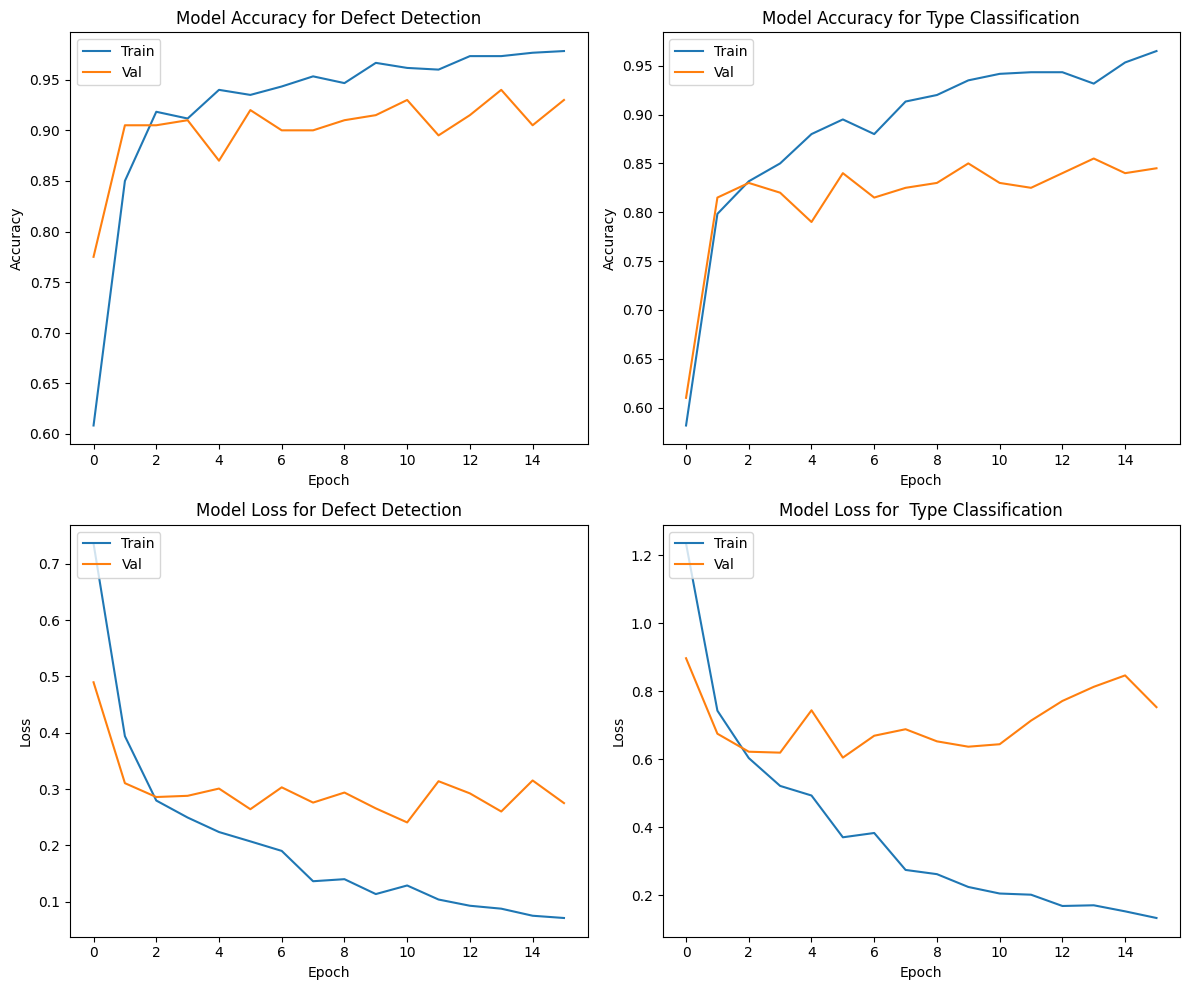

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['defect_output_accuracy'])
plt.plot(history.history['val_defect_output_accuracy'])
plt.title('Model Accuracy for Defect Detection')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation accuracy values for defect type classification
plt.subplot(2, 2, 2)
plt.plot(history.history['type_output_accuracy'])
plt.plot(history.history['val_type_output_accuracy'])
plt.title('Model Accuracy for Type Classification')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values for defect detection
plt.subplot(2, 2, 3)
plt.plot(history.history['defect_output_loss'])
plt.plot(history.history['val_defect_output_loss'])
plt.title('Model Loss for Defect Detection')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')


plt.subplot(2, 2, 4)
plt.plot(history.history['type_output_loss'])
plt.plot(history.history['val_type_output_loss'])
plt.title('Model Loss for  Type Classification')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')


plt.tight_layout()
plt.show()
